# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course, using Python eco-system tools, instead of R. This is lecture "Simple linear regression".  See the previous blog posts for my motivation.


## Initial Notebook Setup

```watermark``` helps document the Python and package environment; ```black``` is my preferred Python formatter.

In [3]:
%load_ext watermark

In [4]:
%load_ext lab_black

In [5]:
%matplotlib inline

All imports go here.  ```numpy``` handles low level numerical computing, ```pandas``` handles high level datatable structures, ```seaborn``` handles easy vizualization.

```scipy.stats``` and ```statsmodels``` handle most of the statistics.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sn

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import (
    wls_prediction_std,
)

from statsmodels.stats.stattools import jarque_bera

import os

D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


----
## Create Data

We create a dataset with Gaussian noise, and a very weak relation beyween ```x``` and ```y```

In [7]:
n_data = 50

beta_0 = 1.5
beta_1 = 0.1
sigma = 2

x = np.random.normal(0, 1, n_data)
x = np.array(sorted(x))
y = beta_0 + x * beta_1
#
y = y + np.random.normal(0, 1, n_data) * sigma

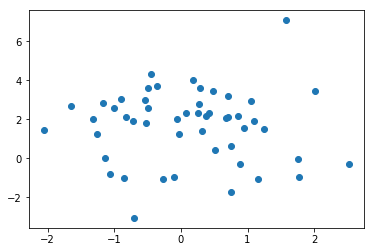

In [8]:
_ = plt.plot(x, y, 'o')

Life becomes a lot easier, if we create a Pandas dataframe with this data.  This done, we then perform a Ordinary Least Squares (OLS) fit of a line to the data.  We use the R-style symbolic model specification (saying ```y``` depends on ```x``` linearly)

In [9]:
df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

res = ols('y ~ x', data=data).fit()

res.params

Intercept    1.698655
x           -0.032369
dtype: float64

In [10]:
y_hat = res.predict()

We use the minimal ```matplotlib```  calls to plot our data nd best-fit line

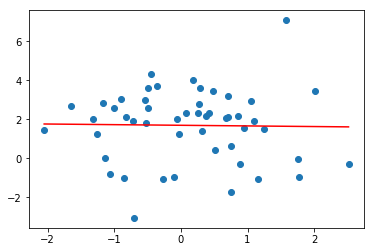

In [11]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, y_hat, 'r-')

### Error / Loss Functions

One question of interest is "If we choose an other metric to minimize (say absolute error) are the results much different?"

In [12]:
def loss_sq(y1, y2):

    return (y1 - y2) ** 2


# end loss


def loss_abs(y1, y2):
    return np.abs(y1 - y2)


# end loss_abs

We build a grid of intercept and slope values, compute the metric, and plot the result

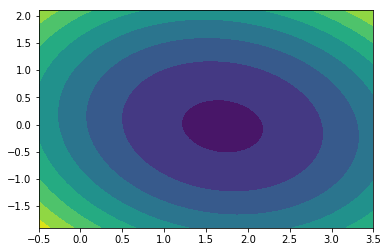

In [13]:
b1_grid = np.linspace(beta_1 - 2, beta_1 + 2, 50)
b0_grid = np.linspace(beta_0 - 2, beta_0 + 2, 50)
bxx, byy = np.meshgrid(b0_grid, b1_grid)
zz = np.zeros((50, 50))


for i in range(len(bxx)):  # run over all intercepts
    for j in range(len(byy)):  # run over all slopes
        sum = 0
        for k in range(len(x)):
            y_predict = bxx[i, j] + byy[i, j] * x[k]
            loss = loss_sq(y_predict, y[k])
            sum = sum + loss
        # end for
        zz[i, j] = sum
    # end for
# end for

h = plt.contourf(bxx, byy, zz)

This time we adjust ```alpha```, and add contour lines to show how close the OLS fit is to the true value

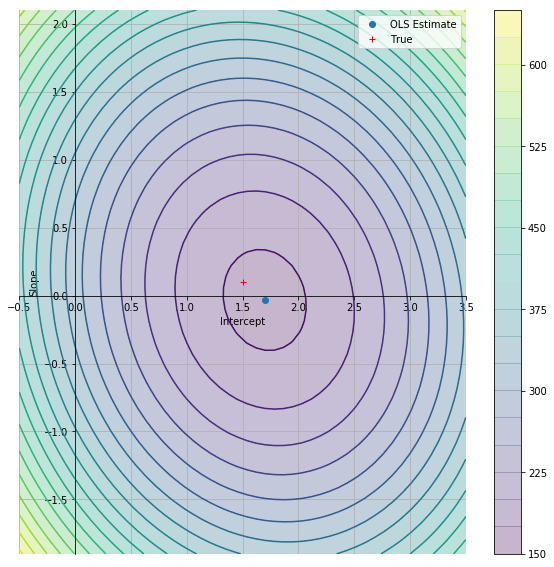

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

cnt = ax.contour(bxx, byy, zz, levels=20)
cnt2 = ax.contourf(bxx, byy, zz, levels=20, alpha=0.3)
fig.colorbar(cnt2, ax=ax)
ax.grid()

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(
    [res.params[0]],
    [res.params[1]],
    'o',
    label='OLS Estimate',
)
ax.plot([beta_0], [beta_1], 'r+', label='True')

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')

ax.legend(loc='best')

We now do the same for the sum of absolute error.  It turns out the difference is minimal


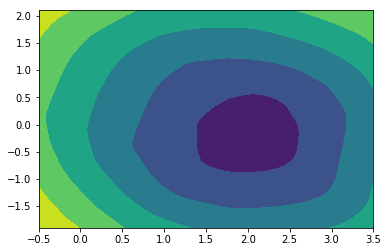

In [15]:
b1_grid = np.linspace(beta_1 - 2, beta_1 + 2, 50)
b0_grid = np.linspace(beta_0 - 2, beta_0 + 2, 50)
bxx, byy = np.meshgrid(b0_grid, b1_grid)
zz = np.zeros((50, 50))


for i in range(len(bxx)):  # run over all intercepts
    for j in range(len(byy)):  # run over all slopes
        sum = 0
        for k in range(len(x)):
            y_predict = bxx[i, j] + byy[i, j] * x[k]
            loss = loss_abs(y_predict, y[k])
            sum = sum + loss
        # end for
        zz[i, j] = sum
    # end for
# end for

h = plt.contourf(bxx, byy, zz)

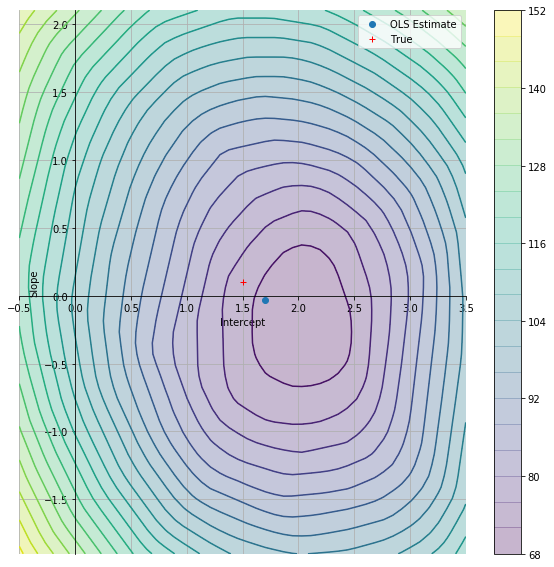

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

cnt = ax.contour(bxx, byy, zz, levels=20)
cnt2 = ax.contourf(bxx, byy, zz, levels=20, alpha=0.3)
fig.colorbar(cnt2, ax=ax)
ax.grid()

ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(
    [res.params[0]],
    [res.params[1]],
    'o',
    label='OLS Estimate',
)
ax.plot([beta_0], [beta_1], 'r+', label='True')

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')

ax.legend(loc='best')

We now repeat the exercise for OLS, with different true slope and intercept, and plot the 3D total error surface

In [17]:
n_data = 50

beta_0 = 10
beta_1 = 5
sigma = 2

x = np.random.normal(0, 1, n_data)
x = np.array(sorted(x))
y = beta_0 + x * beta_1
#
y = y + np.random.normal(0, 1, n_data) * sigma

In [18]:
df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

res = ols('y ~ x', data=data).fit()

res.params

Intercept    9.669345
x            5.381967
dtype: float64

In [19]:
y_hat = res.predict()

Filled contour plot; detail is lost in this default plot

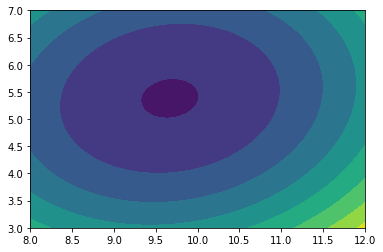

In [20]:
b1_grid = np.linspace(beta_1 - 2, beta_1 + 2, 50)
b0_grid = np.linspace(beta_0 - 2, beta_0 + 2, 50)
bxx, byy = np.meshgrid(b0_grid, b1_grid)
zz = np.zeros((50, 50))


for i in range(len(bxx)):  # run over all intercepts
    for j in range(len(byy)):  # run over all slopes
        sum = 0
        for k in range(len(x)):
            y_predict = bxx[i, j] + byy[i, j] * x[k]
            loss = loss_sq(y_predict, y[k])
            sum = sum + loss
        # end for
        zz[i, j] = sum
    # end for
# end for

h = plt.contourf(bxx, byy, zz)

As before adjust ```alpha``` of the fill, and add contour lines

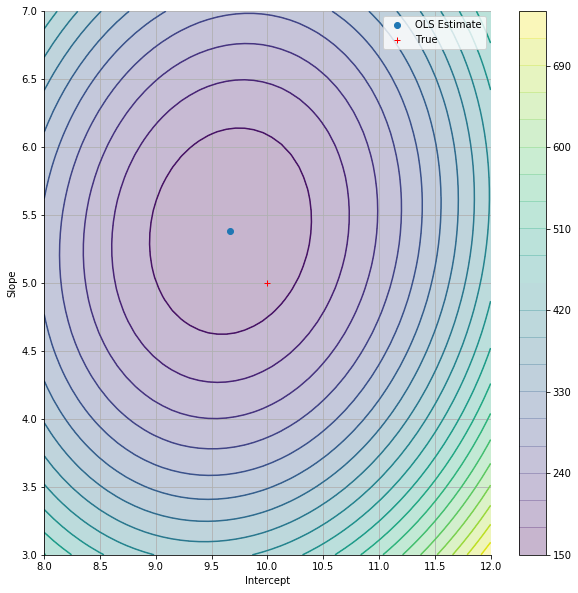

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

cnt = ax.contour(bxx, byy, zz, levels=20)
cnt2 = ax.contourf(bxx, byy, zz, levels=20, alpha=0.3)
fig.colorbar(cnt2, ax=ax)
ax.grid()

# ax.spines['bottom'].set_position('zero')
# ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(
    [res.params[0]],
    [res.params[1]],
    'o',
    label='OLS Estimate',
)
ax.plot([beta_0], [beta_1], 'r+', label='True')

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')

ax.legend(loc='best')

### 3D Surface Plots

We invert the error surface for clarity, and show the error surface.

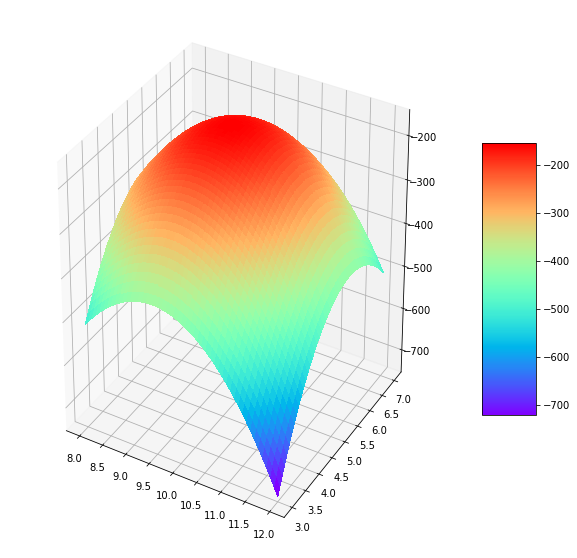

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(
    bxx,
    byy,
    -zz,
    linewidth=1,
    antialiased=False,
    cmap='rainbow',
)

fig.colorbar(surf, shrink=0.5, aspect=5)

The figure above looks nice, but we can add more detail; planar contour plot, line down from surface maximum (i.e. minimum error), title, legend, axes labels

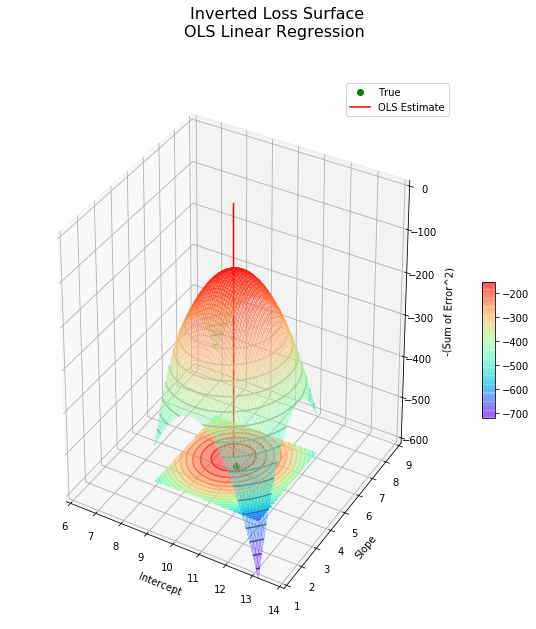

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(
    bxx,
    byy,
    -zz,
    linewidth=1,
    antialiased=False,
    cmap='rainbow',
    alpha=0.3,
)

z_offset = -600

ax.set_xlim(beta_0 - 4, beta_0 + 4)
ax.set_ylim(beta_1 - 4, beta_1 + 4)
ax.set_zlim(z_offset, 0)

ax.contourf(
    bxx,
    byy,
    -zz,
    zdir='z',
    offset=z_offset,
    cmap='rainbow',
    alpha=0.5,
    levels=20,
)
ax.contour(
    bxx,
    byy,
    -zz,
    zdir='z',
    offset=z_offset,
    cmap='rainbow',
    alpha=0.9,
    levels=20,
)

ax.contour(
    bxx,
    byy,
    -zz,
    zdir='z',
    cmap='gray',
    alpha=0.8,
    levels=20,
)

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('\n\n-(Sum of Error^2)')

ax.plot(
    [beta_0], [beta_1], [z_offset + 1], 'go', label='True'
)
ax.plot(
    [res.params[0], res.params[0]],
    [res.params[1], res.params[1]],
    [z_offset + 1, 0],
    'r-',
    label='OLS Estimate',
)

ax.legend(loc='best')
fig.suptitle(
    'Inverted Loss Surface\n' + 'OLS Linear Regression ',
    fontsize=16,
)


fig.colorbar(surf, shrink=0.25, aspect=10)

-----
## Wages Data

We now look at a different data set: one linking wages with education level

### Load and explore data

In [24]:
wages = pd.read_csv('../data/wage.csv')

In [25]:
wages.head()

,education,logwage
0,16.750000,2.845000
1,15.000000,2.446667
2,10.000000,1.560000
3,12.666667,2.099167
4,15.000000,2.490000


In [26]:
wages['logwage'].mean()

2.240279398911975

### Perform OLS

Fit a line to the data, and display

In [27]:
res = ols('logwage ~ education', data=wages).fit()

In [28]:
res.params

Intercept    1.239194
education    0.078600
dtype: float64

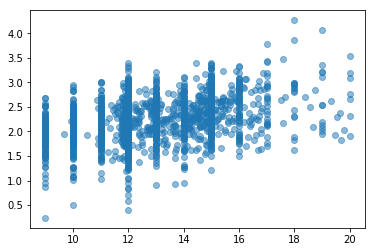

In [29]:
_ = plt.plot(
    wages['education'], wages['logwage'], 'o', alpha=0.5
)

Because we have so many data points with the same ```x``` value, we "jitter" the x values by adding random noise.  This gives us a better sense on where most of the datapoints are to be found.  We also set ```alpha``` to a smaller value, so plotted points less obscure underlying points

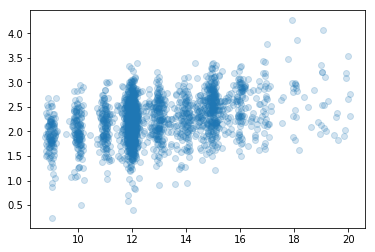

In [30]:
_ = plt.plot(
    wages['education']
    + np.random.normal(0, 0.1, len(wages['education'])),
    wages['logwage'],
    'o',
    alpha=0.2,
)

Reduce ```alpha``` still further, and plot the line of best fit.

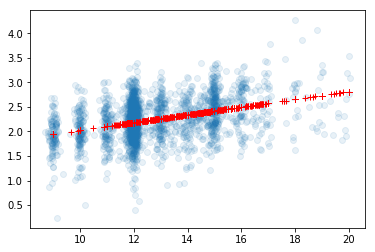

In [31]:
_ = plt.plot(
    wages['education']
    + np.random.normal(0, 0.1, len(wages['education'])),
    wages['logwage'],
    'o',
    alpha=0.1,
)
_ = plt.plot(wages['education'], res.predict(), 'r+')

In [32]:
res.params

Intercept    1.239194
education    0.078600
dtype: float64

In order to make sure we understand the OLS results, we compute the best-fit intercept and slope manually

In [33]:
x_mean = wages['education'].mean()
y_mean = wages['logwage'].mean()

sxx = (wages['education'] - x_mean) @ (
    wages['education'] - x_mean
).T

cov_x_y = (wages['education'] - x_mean) @ (
    wages['logwage'] - y_mean
).T

In [34]:
beta_1_hat = cov_x_y / sxx

beta_0_hat = y_mean - x_mean * beta_1_hat

print(f' beta 0 = {beta_0_hat}, beta 1 = {beta_1_hat}')

 beta 0 = 1.239194326803034, beta 1 = 0.0785995102448242


In [35]:
sigma2_hat = (
    1
    / (len(wages['education']) - 2)
    * (wages['logwage'] - res.predict())
    @ (wages['logwage'] - res.predict()).T
)

In [36]:
sigma_hat = np.sqrt(sigma2_hat)
sigma_hat

0.4037827822998898

Display the OLS results

In [37]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     340.0
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           1.15e-70
Time:                        21:04:47   Log-Likelihood:                -1114.3
No. Observations:                2178   AIC:                             2233.
Df Residuals:                    2176   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2392      0.055     22.541      0.000       1.131       1.347
education      0.0786      0.004     18.440      0.000       0.070       0.087
==============================================================================
Omnibus:                       46.662   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.725
Skew:                          -0.269   Prob(JB):                     1.07e-13
Kurtosis:                       3.606   Cond. No.                         82.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
res.cov_params()

,Intercept,education
Intercept,0.003022,-0.000231
education,-0.000231,0.000018


We see that the manually calculated values match those displayed by the ```summary()``` method.  The manually calculated R^2 value also is identical, as are the parameter standard errors

In [39]:
res.ess / res.centered_tss

0.13514534147541912

The equations for the standard error for the slope (beta) and intercept (alpha) are shown below

$$s_{\widehat {\beta }}={\sigma }{\sqrt { {\frac {1} {\sum _{i=1}^{n}({x_{i}}-{\bar x})^{2}}}}}$$

$$s_{\widehat {\alpha }}=s_{\widehat {\beta }}{\sqrt {{\frac {1}{n}}\sum _{i=1}^{n}x_{i}^{2}}}$$

In [40]:
se_beta1 = sigma_hat * np.sqrt(1 / (sxx))
sum_x2 = wages['education'] @ wages['education'].T
se_beta0 = se_beta1 * np.sqrt(
    sum_x2 / len(wages['education'])
)

print(f'Standard Error beta 1 = {se_beta1}')
print(f'Standard Error beta 0 = {se_beta0}')

Standard Error beta 1 = 0.004262470820775879
Standard Error beta 0 = 0.05497420521139725



---------
## Reproducibility

In [41]:
%watermark -h -iv
%watermark

statsmodels 0.9.0
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
pandas      1.0.0
seaborn     0.9.0
host name: DESKTOP-SODFUN6
2020-03-18T21:04:47+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
